# Machine Learning Intro
## Labs day 1

Please complete the exercises assignments in this notebook.

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all" 
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Assignment 1: Handwritten digit recognition
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [3]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

Class label: 5


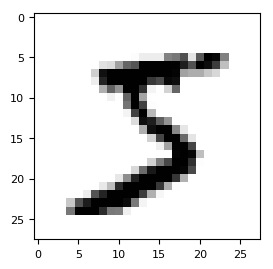

In [4]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); 
# Take the first example, reshape to a 28x28 image and plot
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.gray_r) 
print("Class label:",y[0]) # Print the correct class label

### Part 1
- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?

In [5]:
# Subsample for testing
X = X[:7000]
y = y[:7000]

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split data as requested
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=6000)
knn = KNeighborsClassifier(n_jobs = -1)

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.947000


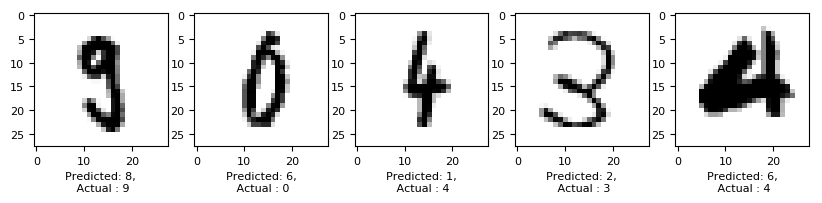

In [7]:
# Get bad predictions (indices of non-matching predictions)
y_pred = knn.predict(X_test)
misclassified_samples = np.nonzero(y_pred != y_test)[0]

# Show first three
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %d,\n Actual : %d" % (y_pred[i],y_test[i]))
plt.show();

In most of the cases, the written digits are indeed easy to mistake, so our kNN model does fairly well, but there is room for improvement.

### Part 2
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same using GridSearchCV or RandomizedSearchCV. What is the optimal value for k?

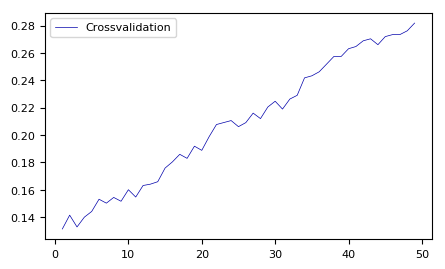

In [9]:
from sklearn.model_selection import cross_val_score

# 10% stratified subsample (by stratified splitting and ignoring the test sets)
Xs, _, ys, _ = train_test_split(X, y, train_size=0.1, stratify=y)

# Result buffers
k_values = range(1,50)
cv_scores = []

# Loop over all k values, compute and store CV score, plot
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores.append(1 - np.mean(cross_val_score(knn, Xs, ys, cv = 10, n_jobs = -1)))
plt.plot(k_values, cv_scores, label="Crossvalidation")
plt.legend(loc="best")
plt.show();

In [13]:
from sklearn.model_selection import GridSearchCV 

param_grid = {'n_neighbors': k_values}
grid_search = GridSearchCV(knn, param_grid, cv=10, n_jobs=-1)
grid_search.fit(Xs, ys)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'n_neighbors': 1}
Best cross-validation score: 0.87


The plot shows that the optimal value of k is very low (close to 1). Larger values result in underfitting.
The bootstrap is more pessimistic than cross-validation, mainly because the training samples are smaller (63% vs 90%). The training set size has a big influence on kNN performance.

### Part 3
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report the optimal performance. Can you get better results than kNN?

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# The classifiers. dual=False is necessary to use L2 regularization later
clfs = [KNeighborsClassifier(), LinearSVC(dual=False), LogisticRegression(n_jobs=-1)]

# Performance with hyperparameter defaults for each classifier
for clf in clfs:
    score = np.mean(cross_val_score(clf, Xs, ys, cv = 10))
    print("%s score: %.4f" % (clf.__class__.__name__, score))

KNeighborsClassifier score: 0.8558
LinearSVC score: 0.8369
LogisticRegression score: 0.8569


In [ ]:
from sklearn.model_selection import GridSearchCV 

# Define the hyperparameter grid
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l1','l2']}

# To organize the plots
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

# Loop over the linear classifiers, optimize parameters
for nr, clf in enumerate(clfs[1:]):
    grid_search = GridSearchCV(clf, param_grid, cv=10).fit(Xs, ys)
    print("%s :" % clf.__class__.__name__)
    print(" Best configuration: %s" %(grid_search.best_params_))
    print(" Best cross-validation score: %.4f" %(grid_search.best_score_))  

    # Plot the cross-validation scores
    axes[nr].set_title(clf.__class__.__name__)
    scores = np.array(grid_search.cv_results_['mean_test_score']).reshape(9, 2)
    mglearn.tools.heatmap(np.transpose(scores), xlabel='C', xticklabels=param_grid['C'],
                          ylabel='penalty', yticklabels=param_grid['penalty'], 
                          cmap="viridis", ax=axes[nr])
fig.show();

Report all results clearly and interpret the results. 

Hint: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.  
Hint: you can easily take a 10% stratified subsample in scikit-learn like this, and then continue with X_sample and y_sample. You can also use this subsample in the 3rd subquestion if it takes too long to run in on the whole dataset.
```X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.1, stratify=y)```  
Hint: the $C$ parameter is typically varied on a log scale between $2^{-15}$ and $2^{15}$. You can also use something like [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]. The important thing is that you check that the optimal value lies within the range that you checked.

## Assignment 2: A regression benchmark
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

Hint: negative mean squared error (neg_MSE) is a standard scoring technique in ```GridSearchCV``` and ```cross_val_score```. You'll have to inverse the sign and compute the square roots yourself. Of course, during a grid search you can just use neg_MSE, the optimal hyperparameter values will be the same.

In [ ]:
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Hyperparameter grids for Ridge, Lasso (we asume that the default l2 loss is best), and kNN.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
param_knn = {'n_neighbors': [1,3,5,7,11,15,17,19,21,23,25,27,29,31,33,35]}

for reg, param_grid in zip([Ridge(), Lasso(), KNeighborsRegressor()],
                            [param_ridge,param_lasso,param_knn]):
    grid_search = GridSearchCV(reg, param_grid, scoring="neg_mean_squared_error", cv=10)
    grid_search.fit(X, y)
              
    print("%s :" % (reg.__class__.__name__))
    print(" Best parameter(s): {}".format(grid_search.best_params_))
    print(" Best RMSE: {:.2f}".format(np.sqrt(-grid_search.best_score_)))

